In [1]:
#필요한 라이브러리 불러오기
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import re

# 0. 전처리

In [2]:
토양_원본 = pd.read_excel('D:/Programming/Jupyter/02.data/DS2_data/토양오염.xlsx')

In [3]:
# "구분" 열을 "시도별"로 변경
토양_원본 = 토양_원본.rename(columns={'구분': '시도별'})
# '제주특별자치도'를 '제주도'로 변경
토양_원본['시도별'] = 토양_원본['시도별'].replace({'제주특별자치도': '제주도'})

In [4]:
# 중간 결과 저장
토양 = 토양_원본.copy()

In [5]:
# '지점수 (개)' 열의 데이터에서 "("부터 ")"까지의 문자열을 제거하는 함수
def remove_parentheses(value):
    return re.sub(r'\([^)]*\)', '', str(value))

# '지점수 (개)' 열에 적용하여 괄호 제거
토양['지점수 (개)'] = 토양['지점수 (개)'].apply(remove_parentheses)

# 결과 출력
토양['지점수 (개)']

0      199
1      524
2      326
3      304
4      329
      ... 
181     50
182     50
183     50
184     50
185     50
Name: 지점수 (개), Length: 186, dtype: object

In [6]:
# '-'를 NaN으로 대체
토양.replace('-', np.nan, inplace=True)

In [7]:
# '지점수 (개)'와 '시료수 (개)' 열의 형식 변경
토양['지점수 (개)'] = pd.to_numeric(토양['지점수 (개)'], errors='coerce')
토양['시료수 (개)'] = pd.to_numeric(토양['시료수 (개)'], errors='coerce')

# 수치형 열의 형식 변경
수치형_컬럼 = 토양.columns[4:]  # '카드뮴 Cd (mg/kg)'부터 끝까지의 열 선택
토양[수치형_컬럼] = 토양[수치형_컬럼].astype(float)

In [8]:
토양.dtypes

시도별                              object
시점                                int64
지점수 (개)                           int64
시료수 (개)                         float64
카드뮴 Cd (mg/kg)                  float64
구리 Cu (mg/kg)                   float64
비소 As (mg/kg)                   float64
수은 Hg (mg/kg)                   float64
납 Pb (mg/kg)                    float64
6가크롬 Cr6+ (mg/kg)               float64
아연 Zn (mg/kg)                   float64
니켈 Ni (mg/kg)                   float64
불소 F (mg/kg)                    float64
유기인 (mg/kg)                     float64
폴리클로리네이티드비페닐 PCB (mg/kg)        float64
시안 CN (mg/kg)                   float64
페놀류 (mg/kg)                     float64
벤젠 톨루엔 에틸벤젠 크실렌 BTEX (mg/kg)    float64
벤젠 (mg/kg)                      float64
톨루엔 (mg/kg)                     float64
에틸벤젠 (mg/kg)                    float64
크실렌 (mg/kg)                     float64
석유계총탄화수소 TPH (mg/kg)            float64
트리클로로에틸렌 TCE (mg/kg)            float64
테트라클로로에틸렌 PCE (mg/kg)           float64


In [9]:
토양.isnull().sum()

시도별                               0
시점                                0
지점수 (개)                           0
시료수 (개)                          16
카드뮴 Cd (mg/kg)                    0
구리 Cu (mg/kg)                     0
비소 As (mg/kg)                     0
수은 Hg (mg/kg)                     0
납 Pb (mg/kg)                      0
6가크롬 Cr6+ (mg/kg)                 3
아연 Zn (mg/kg)                     0
니켈 Ni (mg/kg)                     0
불소 F (mg/kg)                     25
유기인 (mg/kg)                      37
폴리클로리네이티드비페닐 PCB (mg/kg)         60
시안 CN (mg/kg)                     1
페놀류 (mg/kg)                      23
벤젠 톨루엔 에틸벤젠 크실렌 BTEX (mg/kg)    169
벤젠 (mg/kg)                       11
톨루엔 (mg/kg)                      11
에틸벤젠 (mg/kg)                     11
크실렌 (mg/kg)                      11
석유계총탄화수소 TPH (mg/kg)             11
트리클로로에틸렌 TCE (mg/kg)             19
테트라클로로에틸렌 PCE (mg/kg)            20
벤조(a)피렌 (mg/kg)                  56
1,2-디클로로에탄 1,2-DCA (mg/kg)      139
수소이온농도 pH (pH)              

In [10]:
# 2012년도부터는 결측값 전년도 값으로 대체
토양_filled = 토양.groupby('시도별', group_keys=False).apply(lambda group: group.ffill())

# 2011년도 결측값 -> 2012년도 값으로 대체
토양_2011 = 토양_filled[토양_filled['시점'] == 2011]

# 결측값이 있는 열 찾기
columns_with_na = 토양_2011.columns[토양_2011.isna().any()].tolist()

# 결측값이 있는 행의 시도별 추출
for column in columns_with_na:
    na_rows = 토양_2011[토양_2011[column].isna()]['시도별'].unique()

    # 2012년도에서 같은 시도별의 2011년도 값으로 결측값 대체
    for na_row in na_rows:
        # 2011년도의 같은 시도별, 같은 열에 대체
        토양_filled.loc[(토양_filled['시점'] == 2011) & (토양_filled['시도별'] == na_row), column] = 토양_filled[(토양_filled['시점'] == 2012) & (토양_filled['시도별'] == na_row)][column].values[0]

        # 만약에 여전히 결측값이 있다면 다음 년도 값으로 대체
        if 토양_filled[(토양_filled['시점'] == 2011) & (토양_filled['시도별'] == na_row)][column].isna().any():
            토양_filled.loc[(토양_filled['시점'] == 2011) & (토양_filled['시도별'] == na_row), column] = 토양_filled[(토양_filled['시점'] == 2012) & (토양_filled['시도별'] == na_row)][column].bfill().values[0]

# 결과 출력
토양_filled.isnull().sum()


시도별                               0
시점                                0
지점수 (개)                           0
시료수 (개)                           0
카드뮴 Cd (mg/kg)                    0
구리 Cu (mg/kg)                     0
비소 As (mg/kg)                     0
수은 Hg (mg/kg)                     0
납 Pb (mg/kg)                      0
6가크롬 Cr6+ (mg/kg)                 2
아연 Zn (mg/kg)                     0
니켈 Ni (mg/kg)                     0
불소 F (mg/kg)                      7
유기인 (mg/kg)                       5
폴리클로리네이티드비페닐 PCB (mg/kg)         13
시안 CN (mg/kg)                     0
페놀류 (mg/kg)                       5
벤젠 톨루엔 에틸벤젠 크실렌 BTEX (mg/kg)     84
벤젠 (mg/kg)                        2
톨루엔 (mg/kg)                       2
에틸벤젠 (mg/kg)                      2
크실렌 (mg/kg)                       2
석유계총탄화수소 TPH (mg/kg)              1
트리클로로에틸렌 TCE (mg/kg)              3
테트라클로로에틸렌 PCE (mg/kg)             3
벤조(a)피렌 (mg/kg)                  15
1,2-디클로로에탄 1,2-DCA (mg/kg)      138
수소이온농도 pH (pH)              

In [11]:
# 2012년 결측값을 2013년 값으로 대체하는 함수
def fill_missing_values_with_next_year(data, year_column='시점', value_columns=None):
    filled_data = data.copy()
    for col in value_columns:
        for i in range(len(data)):
            if pd.isnull(data.at[i, col]) and data.at[i, year_column] == 2012:
                next_year_value = data.at[i, col]
                next_year_index = i + 1
                while next_year_index < len(data) and pd.isnull(next_year_value):
                    next_year_value = data.at[next_year_index, col]
                    next_year_index += 1
                filled_data.at[i, col] = next_year_value
    return filled_data

# 2012년 결측값을 2013년 값으로 대체
토양_filled = fill_missing_values_with_next_year(토양_filled, value_columns=토양_filled.columns)

# 2011년 결측값을 2012년 값으로 대체하는 함수
def fill_missing_values_with_previous_year(data, year_column='시점', value_columns=None):
    filled_data = data.copy()
    for col in value_columns:
        for i in range(len(data)):
            if pd.isnull(data.at[i, col]) and data.at[i, year_column] == 2011:
                prev_year_value = data.at[i, col]
                prev_year_index = i - 1
                while pd.isnull(prev_year_value) and prev_year_index >= 0:
                    prev_year_value = data.at[prev_year_index, col]
                    prev_year_index -= 1
                filled_data.at[i, col] = prev_year_value
    return filled_data

# 2011년 결측값을 2012년 값으로 대체
토양_filled = fill_missing_values_with_previous_year(토양_filled, value_columns=토양_filled.columns)


In [12]:
# 결과 출력
토양_filled.isnull().sum()

시도별                               0
시점                                0
지점수 (개)                           0
시료수 (개)                           0
카드뮴 Cd (mg/kg)                    0
구리 Cu (mg/kg)                     0
비소 As (mg/kg)                     0
수은 Hg (mg/kg)                     0
납 Pb (mg/kg)                      0
6가크롬 Cr6+ (mg/kg)                 0
아연 Zn (mg/kg)                     0
니켈 Ni (mg/kg)                     0
불소 F (mg/kg)                      0
유기인 (mg/kg)                       0
폴리클로리네이티드비페닐 PCB (mg/kg)          0
시안 CN (mg/kg)                     0
페놀류 (mg/kg)                       0
벤젠 톨루엔 에틸벤젠 크실렌 BTEX (mg/kg)     52
벤젠 (mg/kg)                        0
톨루엔 (mg/kg)                       0
에틸벤젠 (mg/kg)                      0
크실렌 (mg/kg)                       0
석유계총탄화수소 TPH (mg/kg)              0
트리클로로에틸렌 TCE (mg/kg)              0
테트라클로로에틸렌 PCE (mg/kg)             0
벤조(a)피렌 (mg/kg)                   0
1,2-디클로로에탄 1,2-DCA (mg/kg)      106
수소이온농도 pH (pH)              

In [13]:
# 데이터프레임에서 결측값이 많은 열 삭제
토양 = 토양_filled.drop(['벤젠 톨루엔 에틸벤젠 크실렌 BTEX (mg/kg)', '1,2-디클로로에탄 1,2-DCA (mg/kg)'], axis=1)

file_path = r'D:/Programming/Jupyter/02.data/DS2_data/전처리데이터/토양오염_전처리.xlsx'
토양.to_excel(file_path, index=False)

print(f'데이터가 {file_path}에 저장되었습니다.')

# 1. 분석

In [15]:
# 기본 통계 정보 확인
토양.describe()

,시점,지점수 (개),시료수 (개),카드뮴 Cd (mg/kg),구리 Cu (mg/kg),비소 As (mg/kg),수은 Hg (mg/kg),납 Pb (mg/kg),6가크롬 Cr6+ (mg/kg),아연 Zn (mg/kg),...,페놀류 (mg/kg),벤젠 (mg/kg),톨루엔 (mg/kg),에틸벤젠 (mg/kg),크실렌 (mg/kg),석유계총탄화수소 TPH (mg/kg),트리클로로에틸렌 TCE (mg/kg),테트라클로로에틸렌 PCE (mg/kg),벤조(a)피렌 (mg/kg),수소이온농도 pH (pH)
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,...,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,2016.026882,151.860215,197.365591,0.806145,33.950903,5.413081,0.059478,33.728774,0.116672,129.995231,...,0.004796,0.004688,0.481339,0.062586,0.195263,80.892242,0.042586,0.005328,0.019199,7.089505
std,3.157886,85.256572,166.087459,0.812282,21.597239,3.722684,0.075752,19.020848,0.211702,53.719614,...,0.025331,0.014976,4.932767,0.246799,0.877431,88.634739,0.525122,0.046280,0.053240,0.541559
min,2011.000000,15.000000,15.000000,0.000000,7.220000,0.000000,0.000000,12.416000,0.000000,36.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.700000
25%,2013.000000,89.000000,110.000000,0.197000,20.070500,3.408250,0.025250,22.290500,0.000000,96.911500,...,0.000000,0.000000,0.000000,0.000000,0.000000,20.488000,0.000000,0.000000,0.000000,6.730000
50%,2016.000000,136.000000,155.000000,0.493000,27.353000,5.285000,0.039000,28.151000,0.035500,120.167000,...,0.000000,0.000000,0.000000,0.000000,0.000000,54.980000,0.000000,0.000000,0.000000,7.041000
75%,2019.000000,206.000000,220.000000,1.109750,42.959500,6.634500,0.074500,40.868500,0.112750,153.006750,...,0.000000,0.000000,0.020000,0.013750,0.064000,105.867750,0.000000,0.000000,0.009000,7.390250
max,2021.000000,524.000000,922.000000,4.279000,160.057000,35.607000,0.867000,153.694000,1.351000,363.247000,...,0.307000,0.128000,66.846000,2.106000,10.735000,506.414000,7.157000,0.549000,0.385000,8.509000


<h3>지역별 토양 성분 비교</h3>

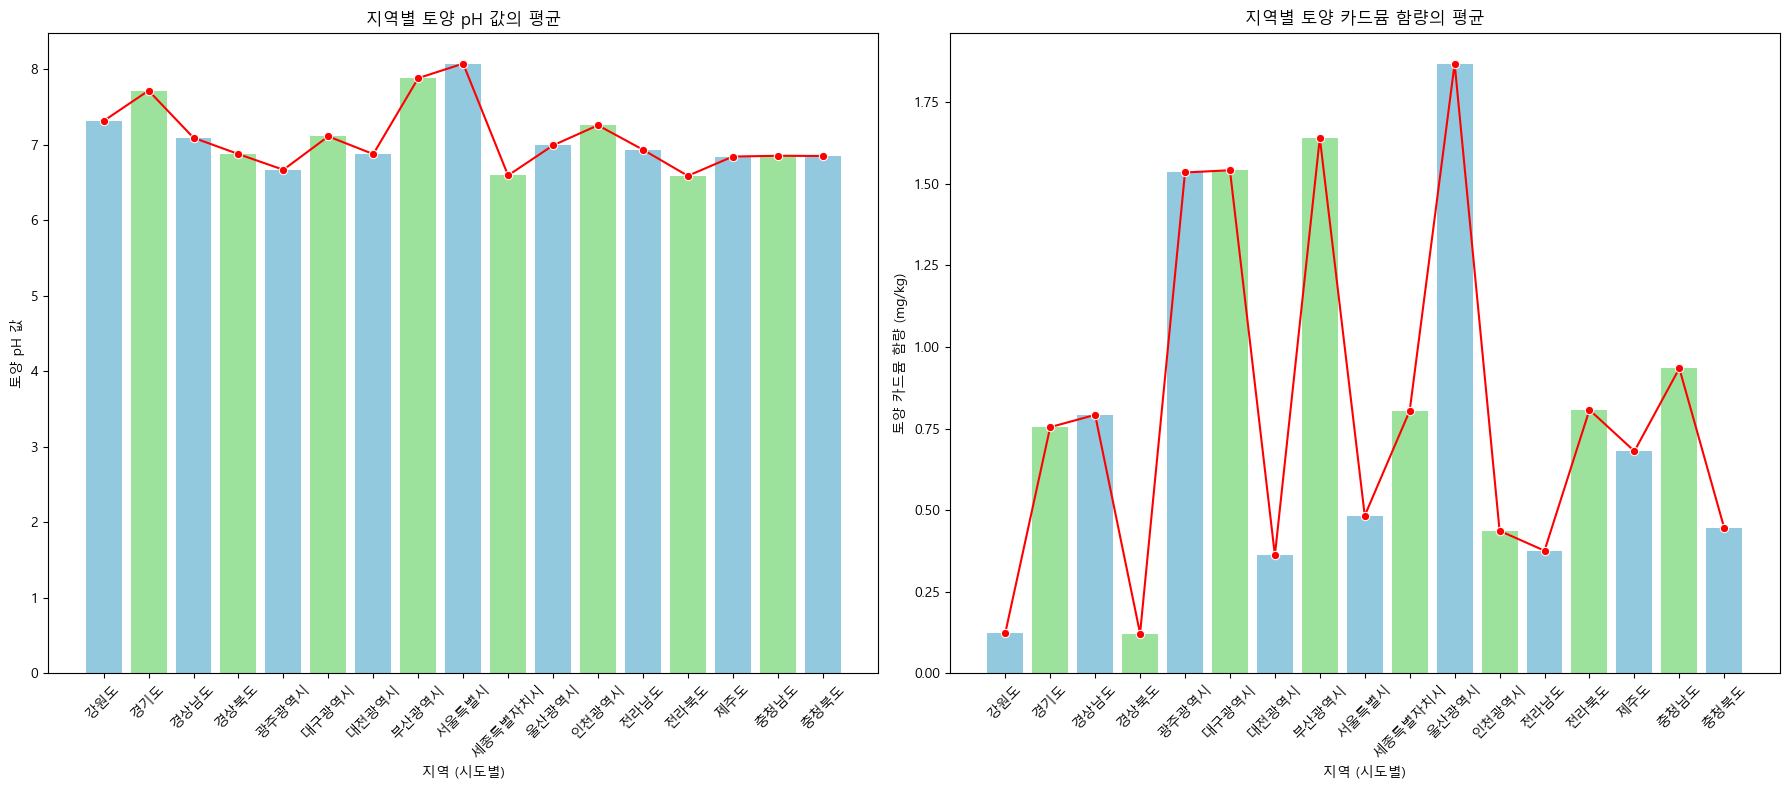

In [21]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 캐시 지우기
from matplotlib import pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

# '토양' 열이 '시도별'로 그룹화하여 각 토양 특성의 평균을 계산
grouped_by_region = 토양.groupby('시도별').mean()

# 색상 설정
palette_colors = ["skyblue", "lightgreen"]

# Seaborn을 사용한 그래프
plt.figure(figsize=(18, 8))

# 첫 번째 그래프 (막대 그래프 - pH 값)
plt.subplot(1, 2, 1)
sns.barplot(x=grouped_by_region.index, y=grouped_by_region['수소이온농도 pH (pH)'], palette=palette_colors)
sns.lineplot(x=grouped_by_region.index, y=grouped_by_region['수소이온농도 pH (pH)'], color='red', marker='o')
plt.title('지역별 토양 pH 값의 평균')
plt.xlabel('지역 (시도별)')
plt.ylabel('토양 pH 값')
plt.xticks(rotation=45)  # x축 레이블 45도 회전

# 두 번째 그래프 (막대 그래프 - 카드뮴 함량)
plt.subplot(1, 2, 2)
sns.barplot(x=grouped_by_region.index, y=grouped_by_region['카드뮴 Cd (mg/kg)'], palette=palette_colors)
sns.lineplot(x=grouped_by_region.index, y=grouped_by_region['카드뮴 Cd (mg/kg)'], color='red', marker='o')
plt.title('지역별 토양 카드뮴 함량의 평균')
plt.xlabel('지역 (시도별)')
plt.ylabel('토양 카드뮴 함량 (mg/kg)')
plt.xticks(rotation=45)  # x축 레이블 45도 회전

# 그래프 간 간격 조절
plt.tight_layout()

# 그래프 표시
plt.show()

1.pH 값에 따른 지역별 차이:

만약 pH 값의 차이가 크다면, 해당 지역의 토양이 산성 또는 알칼리성 정도가 다르다고 볼 수 있습니다. 농작물의 성장에는 적절한 pH가 필요하므로, 특정 지역에서는 pH를 조절하여 농작물 생산성을 향상시킬 필요가 있을 것입니다.

카드뮴 함량에 따른 지역별 차이:

만약 카드뮴 함량의 차이가 크다면, 해당 지역의 토양이 카드뮴 오염에 취약하다고 볼 수 있습니다. 카드뮴은 농작물에 흡수되어 식품으로 전이될 수 있으며, 높은 농도의 카드뮴은 인간 건강에 해를 끼칠 수 있습니다. 따라서 해당 지역에서는 카드뮴 관리 및 제어가 필요할 것입니다.
여러 특성 종합:

여러 토양 특성을 종합하여 분석하면, 해당 지역의 토양 품질을 평가할 수 있습니다. 예를 들어, pH 값, 카드뮴 함량, 유기물 함량 등을 고려하여 토양의 건강 상태를 확인하고, 농작물 생산에 적합한 조건인지를 판단할 수 있습니다.



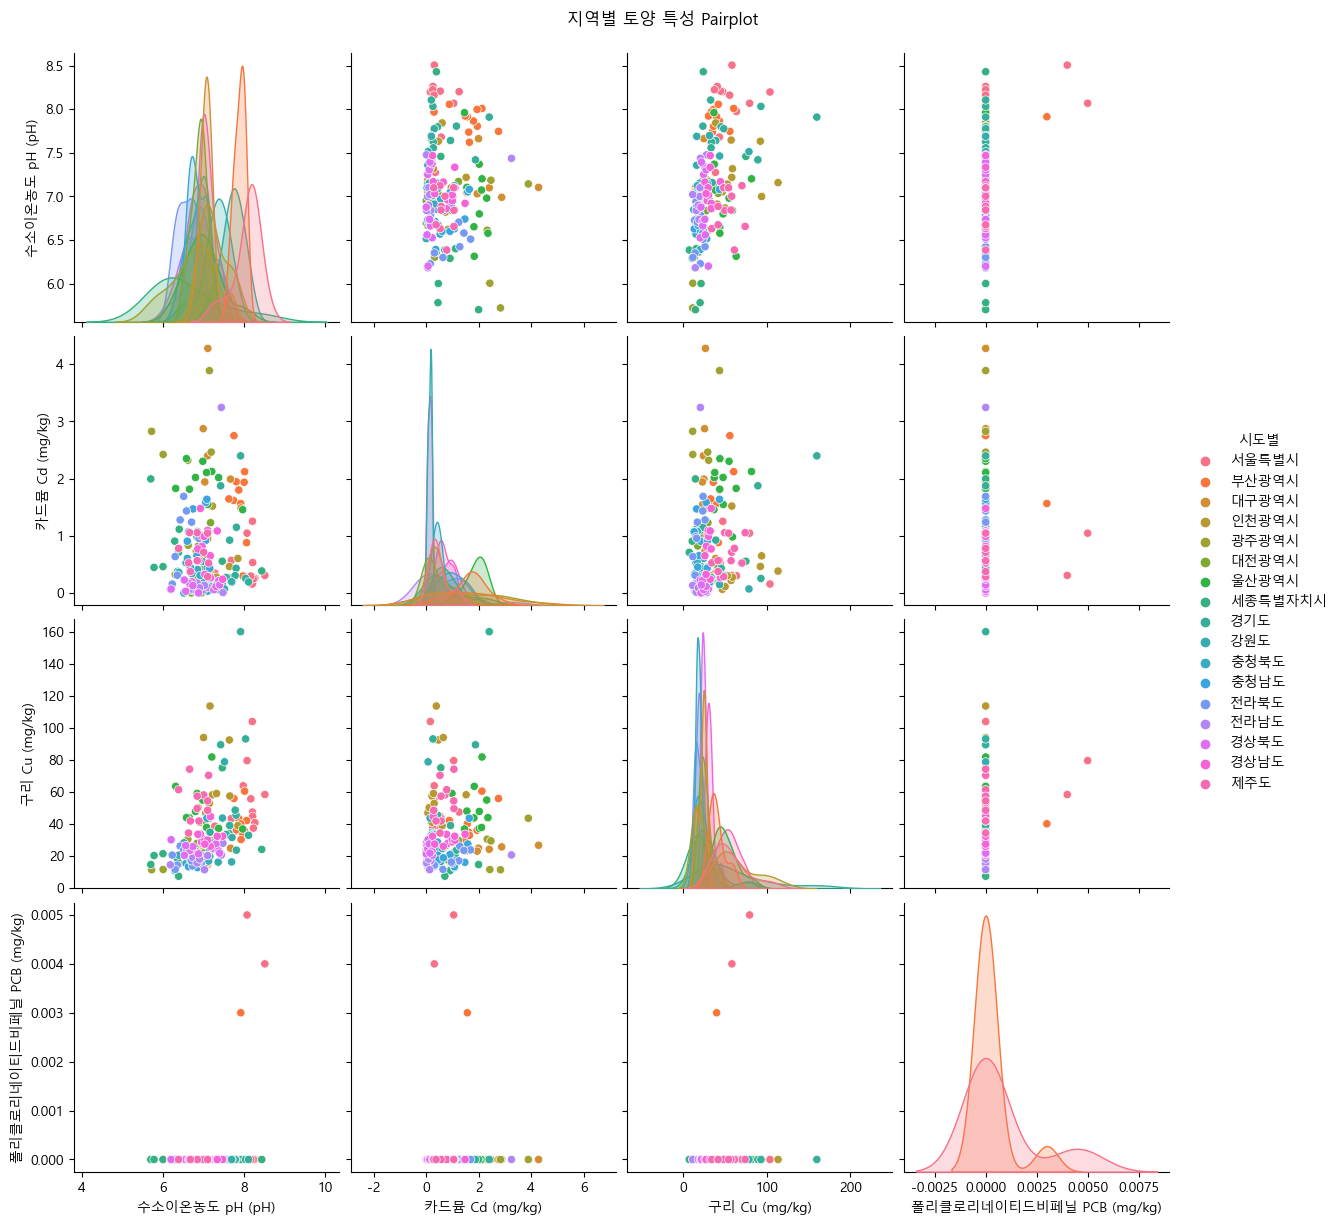

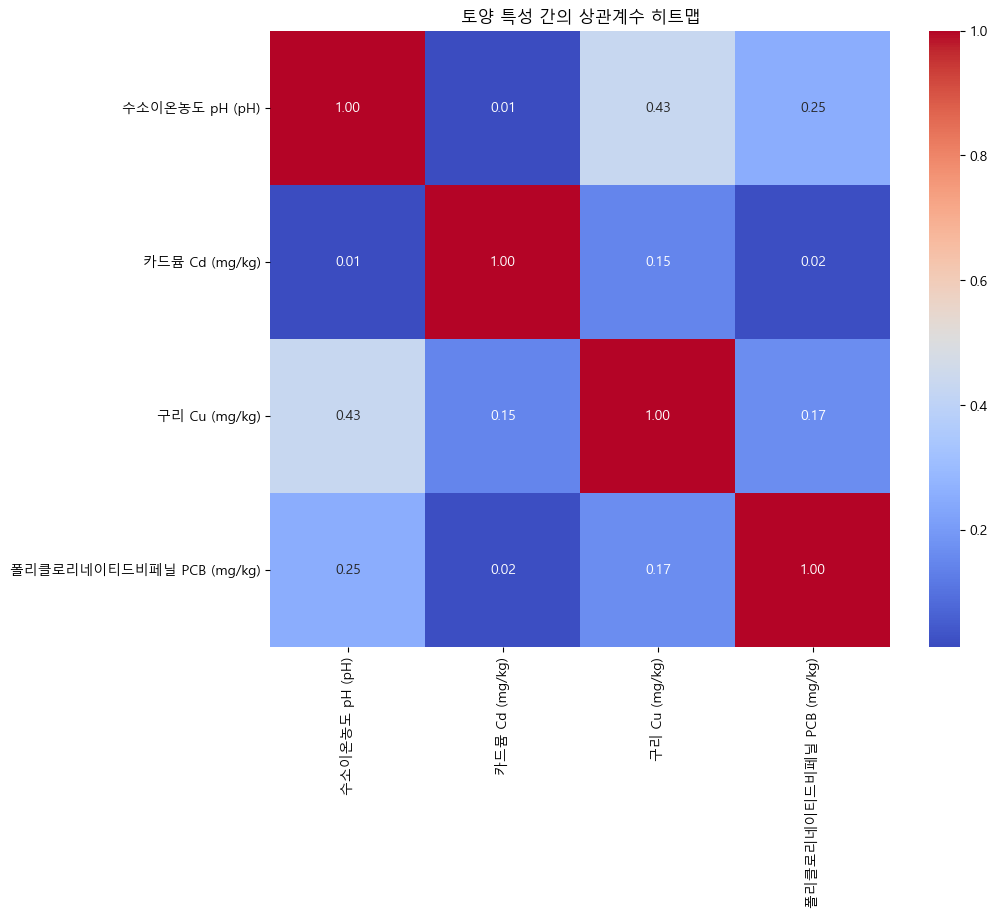

In [22]:
# '토양' 열이 '시도별'로 그룹화하여 각 토양 특성의 평균을 계산
grouped_by_region = 토양.groupby('시도별').mean()

# 선택할 특성들
selected_features = ['수소이온농도 pH (pH)', '카드뮴 Cd (mg/kg)', '구리 Cu (mg/kg)', '폴리클로리네이티드비페닐 PCB (mg/kg)']

# 선택한 특성들에 대한 Pairplot 생성
sns.pairplot(토양, hue='시도별', vars=selected_features, height=3)
plt.suptitle('지역별 토양 특성 Pairplot', y=1.02)
plt.show()

# 특성들 간의 상관계수 히트맵 생성
correlation_matrix = 토양[selected_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('토양 특성 간의 상관계수 히트맵')
plt.show()

Pairplot 해석:

수소이온농도 pH (pH): 지역별로 토양의 pH 값이 상이하게 나타납니다. 특히 몇몇 지역에서는 pH 값의 범위가 다양하게 분포하고 있습니다.
카드뮴 Cd (mg/kg): 특정 지역에서는 카드뮴 함량이 높게 나타나는 경향이 있습니다. 이는 해당 지역의 토양이 카드뮴 오염에 노출되었음을 시사할 수 있습니다.
구리 Cu (mg/kg): 구리 함량은 지역에 따라 차이가 있으며, 일부 지역에서는 높은 구리 함량이 나타납니다.
폴리클로리네이티드비페닐 PCB (mg/kg): PCB 함량도 지역에 따라 다르게 나타납니다. 특히 일부 지역에서는 높은 수치를 보이고 있습니다.
상관계수 히트맵 해석:

특성들 간의 상관계수를 히트맵으로 나타냅니다. 상관계수는 -1에서 1까지의 범위를 가지며, 1에 가까울수록 양의 상관관계, -1에 가까울수록 음의 상관관계를 나타냅니다. 0은 상관관계가 없음을 의미합니다.
특히, 토양의 pH 값과 다른 특성들 간에는 어떤 특별한 상관관계가 나타나지 않는 것으로 보입니다.
결론:

지역별로 토양 특성이 다양하게 나타나고 있으며, 이는 각 지역의 토양 건강 상태에 영향을 미칠 수 있습니다.
특정 지역에서는 카드뮴 및 기타 오염물질의 높은 함량이 나타나고 있어, 해당 지역의 토양 관리 및 환경 정책이 필요할 것으로 보입니다.
토양의 pH 값은 다양하게 분포하고 있지만, 다른 특성들과의 상관관계는 뚜렷하지 않아 보입니다. 따라서 pH 값을 특히 고려하여 농작물의 적절한 조건을 확보하는 것이 중요할 것으로 생각됩니다.

<h3>시간별 토양의 변화</h3>

C:\Users\suin\AppData\Local\Temp\ipykernel_848\390074028.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_by_year = 토양.groupby('시점').mean().reset_index()


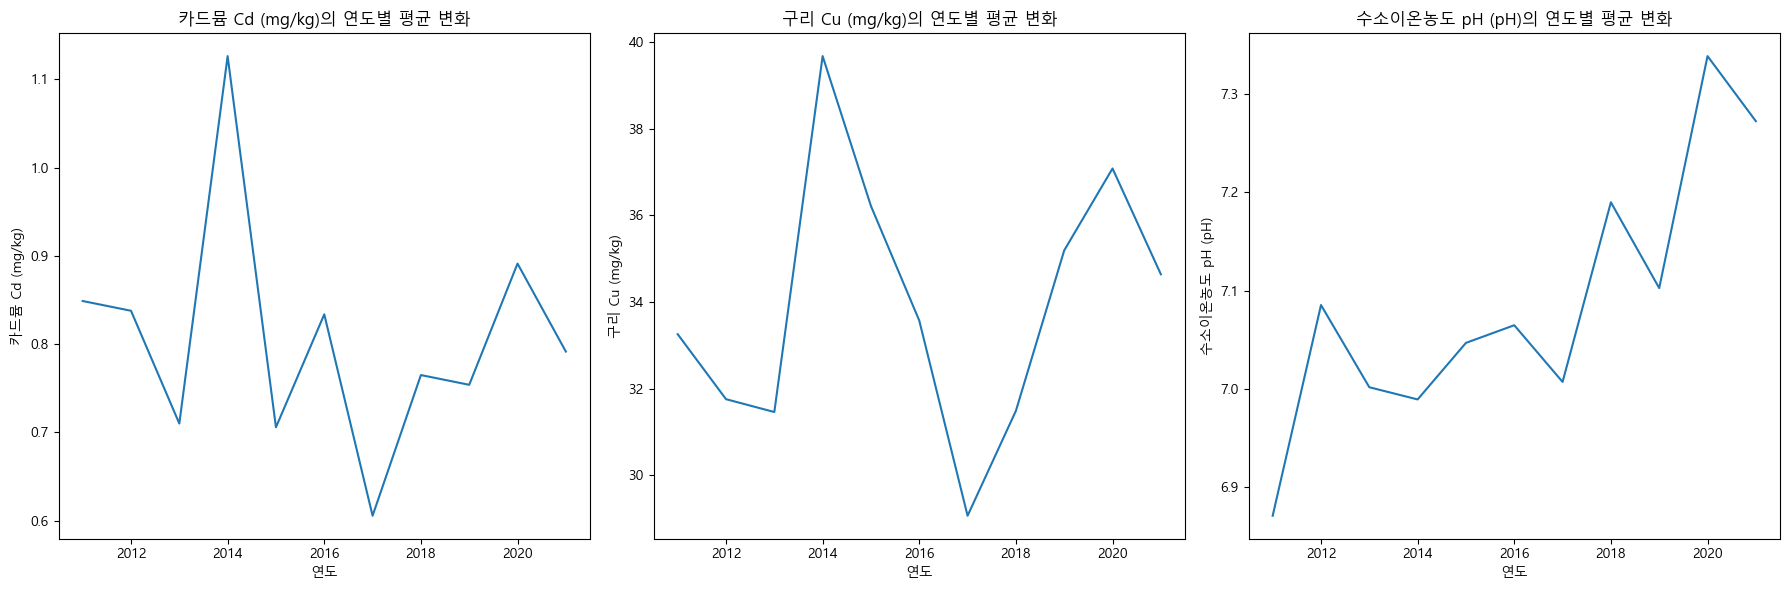

In [23]:
# 연도별 토양 특성의 평균 계산
avg_by_year = 토양.groupby('시점').mean().reset_index()

# 시각화를 위한 데이터 정리 (카드뮴 Cd (mg/kg)를 예시로 함)
plt.figure(figsize=(18, 6))

# 여러 특성들에 대한 시각화 (예시로 3개만 나열)
features_to_visualize = ['카드뮴 Cd (mg/kg)', '구리 Cu (mg/kg)', '수소이온농도 pH (pH)']

for idx, feature in enumerate(features_to_visualize, 1):
    plt.subplot(1, 3, idx)
    sns.lineplot(data=avg_by_year, x='시점', y=feature)
    plt.title(f'{feature}의 연도별 평균 변화')
    plt.xlabel('연도')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

<h3> 
클러스터링 분석:</h3>

비슷한 토양 특성을 갖는 지역들을 클러스터링하여 그룹화할 수 있습니다. 이를 통해 지역 간 유사성을 확인하고, 특정 클러스터에 속하는 지역들이 가지는 공통된 특성을 파악
    

In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

C:\Users\suin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\suin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\suin\AppData\Local\Temp\ipykernel_848\1979347430.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_stats = 토양.groupby('클러스터').mean()


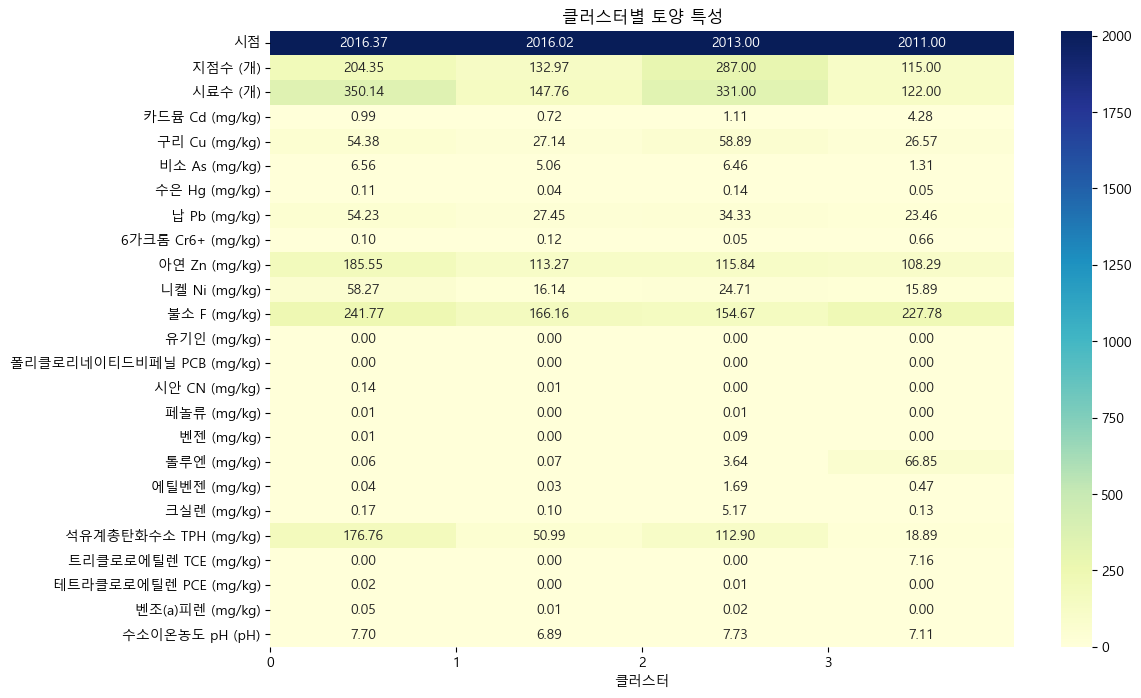

In [25]:
# 토양 데이터 로드 (토양 데이터프레임을 '토양'으로 가정)
# '시도별' 및 '시점' 열을 제외하고 클러스터링을 수행합니다.
토양_cluster = 토양.drop(['시도별', '시점'], axis=1)

# 데이터 스케일링 (중요: 클러스터링 전에는 특성들을 표준화하는 것이 좋습니다.)
scaler = StandardScaler()
토양_scaled = scaler.fit_transform(토양_cluster)

# K-means 클러스터링 수행
num_clusters = 4  # 클러스터의 개수를 설정 (원하는 개수로 수정 가능)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
토양['클러스터'] = kmeans.fit_predict(토양_scaled)

# 클러스터별 통계량 확인
cluster_stats = 토양.groupby('클러스터').mean()

# 클러스터별 특성 시각화 (지역명 추가)
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_stats.T, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('클러스터별 토양 특성')
plt.xticks(ticks=range(len(cluster_stats)), labels=cluster_stats.index, rotation=0)
plt.show()


모르겠움....의미없는거같ㄷr...